<a href="https://colab.research.google.com/github/ashablinski/Capstone/blob/master/Collaborative_Neural_Rec_Sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEURAL COLLABORATIVE RECOMMENDER SYSTEM FOR MOVIES** 

![Neural Nets](https://i.imgur.com/sJBTWPN.png?1!)


In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
print("Run on TensorFlow 2.x")

Run on TensorFlow 2.x


# I. Initial Stage

IMPORT LIBRARIES

In [2]:
# Import Dependencies
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

print("--" * 17)
print("ALL MODULES IMPORTED AND ACTIVATED")

----------------------------------
ALL MODULES IMPORTED AND ACTIVATED


INITIALIZE EAGER EXECUTION

In [3]:
# After eager execution is enabled, operations are executed as they are defined, 
# and Tensor objects hold concrete values.

tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
print("EAGER EXECUTION ENABLED")

EAGER EXECUTION ENABLED


LOADING DATA

In [4]:
# Mounting Google Drive
drive.mount('/content/gdrive')

# Changing Directory
%cd /content/gdrive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [5]:
# Loading Clean Data
ratings_df = pd.read_csv('/content/gdrive/My Drive/CKME 136 Data Analytics - Capstone - Art Shablinski - 501009387/DATA/CLEAN DATA/ratings_df.csv')

# II. Data Pre-Processing

ENCODING VECTORS

In [6]:
# Encoding user vectors
user_ids = ratings_df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Encoding movie vectors
movie_ids = ratings_df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings_df["rating"] = ratings_df["rating"].values.astype(np.float32)

# min and max values will be used to normalize the ratings later
min_rating = min(ratings_df["rating"])
max_rating = max(ratings_df["rating"])

print(
    "Total Number of Users: {}, Total Number of Rated Movies: {}, Min Rating: {}, Max Rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Total Number of Users: 138493, Total Number of Rated Movies: 26744, Min Rating: 0.5, Max Rating: 5.0


DATA SPLIT AND SCALING

In [7]:
# Randomize classes to improve Model generalizability
df = ratings_df.sample(frac=1, random_state=23)
x = ratings_df[["user", "movie"]].values

# Normalize the labels between 0 and 1 to prevent gradients from exploding, and
# making learning of parameters more stable
y = ratings_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Splitting the data to train on 70% of the data and validating on 30%
train_indices = int(0.7 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# III. Model Architecture

DEFINE AND COMPILE THE MODEL

In [9]:
EMBEDDING_SIZE = 50

class CNRC(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(CNRC, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

model = CNRC(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer = keras.optimizers.Adam(lr=0.003), metrics=["Precision", "Recall"]
)

TRAINING THE MODEL

In [11]:
# Destroys the current TF graph and session, and creates a new one.
tf.keras.backend.clear_session()

# Training our Neural Network
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1000,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
14001/14001 [==============================] - 961s 69ms/step - loss: 0.2640 - precision: 0.9880 - recall: 0.9439 - val_loss: 0.2102 - val_precision: 0.9930 - val_recall: 0.7870
Epoch 2/5
14001/14001 [==============================] - 970s 69ms/step - loss: 0.2755 - precision: 0.9879 - recall: 0.9848 - val_loss: 0.1799 - val_precision: 0.9931 - val_recall: 0.7798
Epoch 3/5
14001/14001 [==============================] - 968s 69ms/step - loss: 0.2447 - precision: 0.9879 - recall: 0.9889 - val_loss: 0.1719 - val_precision: 0.9931 - val_recall: 0.7816
Epoch 4/5
14001/14001 [==============================] - 923s 66ms/step - loss: 0.2506 - precision: 0.9879 - recall: 0.9850 - val_loss: 0.1908 - val_precision: 0.9930 - val_recall: 0.7903
Epoch 5/5
14001/14001 [==============================] - 981s 70ms/step - loss: 0.2432 - precision: 0.9879 - recall: 0.9857 - val_loss: 0.1935 - val_precision: 0.9930 - val_recall: 0.7908


SAVING AND SUMMARIZING THE MODEL PARAMETERS

In [12]:
model.save('CNRS')
new_model = keras.models.load_model('CNRS')
new_model.summary()

INFO:tensorflow:Assets written to: CNRS/assets
Model: "cnrc_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  6924650   
_________________________________________________________________
embedding_5 (Embedding)      multiple                  138493    
_________________________________________________________________
embedding_6 (Embedding)      multiple                  1337200   
_________________________________________________________________
embedding_7 (Embedding)      multiple                  26744     
Total params: 8,427,087
Trainable params: 8,427,087
Non-trainable params: 0
_________________________________________________________________


# IV. Evaluation Metrics

DEFINE A PLOTTING FUNCTION

In [13]:
def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


TRAIN VS TEST PERFORMANCE

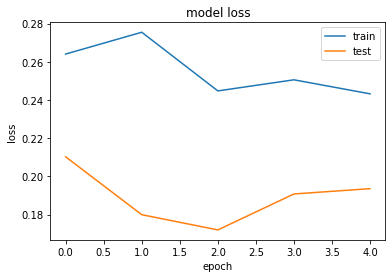

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

TOTAL LOSS, PRECISION AND RECALL VISUALIZED

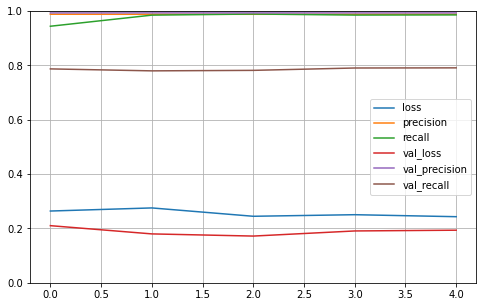

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# TOP 10 RECOMMENDATION GENERATOR

In [21]:
movies_df = pd.read_csv('/content/gdrive/My Drive/CKME 136 Data Analytics - Capstone - Art Shablinski - 501009387/DATA/CLEAN DATA/movies_df.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movies_df[
    ~movies_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movies_df_rows = movies_df[movies_df["movieId"].isin(top_movies_user)]
for row in movies_df_rows.itertuples():
    print(row.title, ":", int(row.year), ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies_df[movies_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", int(row.year), ":", row.genres)


Showing recommendations for user: 121328
Movies with high ratings from user
--------------------------------
Pulp Fiction : 1994 : Comedy|Crime|Drama|Thriller
Devil's Advocate, The : 1997 : Drama|Mystery|Thriller
Road Trip : 2000 : Comedy
Me, Myself & Irene : 2000 : Adventure|Comedy
Kill Bill: Vol. 1 : 2003 : Action|Crime|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb : 1964 : Comedy|War
Rear Window : 1954 : Mystery|Thriller
North by Northwest : 1959 : Action|Adventure|Mystery|Romance|Thriller
Casablanca : 1942 : Drama|Romance
Princess Bride, The : 1987 : Action|Adventure|Comedy|Fantasy|Romance
Apocalypse Now : 1979 : Action|Drama|War
Sting, The : 1973 : Comedy|Crime
Amelie (Fabuleux destin d'Amélie Poulain, Le) : 2001 : Comedy|Romance
Eternal Sunshine of the Spotless Mind : 2004 : Drama|Romance|Sci-Fi
Dark Knight, The : 2008 : Action|Crime|Drama|IMAX
